<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/transfer_learning_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning
### Steps involved
1. Import statements
2. Load data from `tensorflow_datasets`.
2. Split the data into training, validation and test datasets.
3. Select the pre-trained model to be used for transfer learning.
4. Pre-process the data based on the pre-processing needs of the pre-trained model.
5. Perform data augmentation.
6. Load the pre-trained model by setting `include_top=False`
7. Create input layer
8. Pass the input through the pre-trained model.
9. Create output layer with appropriate activation function
10. Create model using `tf.keras.Model` and passing the inputs and outputs.
11. Create early stopping, model checkpoint & tensorboard callbacks.
12. Train the model
13. plot the loss curve.
14. Evaluate the model on test dataset.
15. Unfreeze a few top layers in the base model
16. Train the model
17. Plot the loss curve
18. Evaluate the model on test dataset.

In [1]:
# 1. import
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

print(f" Tensorflow Version : {tf.__version__}")

 Tensorflow Version : 2.12.0


In [2]:
target_dataset="food101"
print(f" {target_dataset} available in Tensorflow dataset list : {target_dataset in tfds.list_builders()}")

 food101 available in Tensorflow dataset list : True


In [3]:
# 2. Download the dataset from tensorflow_datasets
dataset,info= tfds.load("food101", as_supervised=True, with_info=True)
dataset_train_size= info.splits['train'].num_examples
dataset_valid_size= info.splits['validation'].num_examples
class_names= info.features['label'].names
n_classes= info.features['label'].num_classes
dataset_train_size, dataset_valid_size, class_names[:10], n_classes

(75750,
 25250,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 101)

In [4]:
# 3. Create train , validation and test splits.
## Since the dataset may or may not contain validation and test split, lets split the training
## set into train , validation and tests.
test_set_raw, valid_set_raw, train_set_raw= tfds.load("food101"
                                                      ,split=["train[:10%]","train[10%:25%]","train[25%:]"]
                                                      ,as_supervised=True)
len(test_set_raw),len(valid_set_raw), len(train_set_raw)

(7575, 11363, 56812)

Let us check one image from each split

In [5]:
def display_image_and_details(test_image:None, valid_image:None, train_image:None):
  """
  The function will dispaly image in addition to the following information about image
  Image Tensor shape
  Image Label
  Image Label in String
  Args:
    test_image: tensorflow.python.data.ops.take_op._TakeDataset
    valid_image : tensorflow.python.data.ops.take_op._TakeDataset
    train_image: tensorflow.python.data.ops.take_op._TakeDataset
  Returns:
    None
  """
  gs = gridspec.GridSpec(1, 3)

  plt.figure(figsize=(15,7))
  for te_image,te_label in test_image:
    print(f"""
      Test Image Shape : {te_image.shape}
      Test Image dtype: {te_image.dtype}
      Test Image Label: {te_label}
      Test Image Label: {class_names[te_label]}
      Test Image max { tf.reduce_max(te_image)} and min {tf.reduce_min(te_image)}
          """)
    ax = pl.subplot(gs[0, 0])
    plt.imshow(te_image)
    plt.title(f"Test : {class_names[te_label]}")
    plt.axis(False)

  for va_image,va_label in valid_image:
    print(f"""
      Valid Image Shape : {va_image.shape}
      Valid Image dtype: {va_image.dtype}
      Valid Image Label: {va_label}
      Valid Image Label: {class_names[va_label]}
      Valid Image max { tf.reduce_max(va_image)} and min {tf.reduce_min(va_image)}
          """)
    ax = pl.subplot(gs[0, 1])
    plt.imshow(va_image)
    plt.title(f"Valid : {class_names[va_label]}")
    plt.axis(False)

  for tr_image,tr_label in train_image:
    print(f"""
      Train Image Shape : {tr_image.shape}
      Train Image dtype: {tr_image.dtype}
      Train Image Label: {tr_label}
      Train Image Label: {class_names[tr_label]}
      Train Image max { tf.reduce_max(tr_image)} and min {tf.reduce_min(tr_image)}
          """)
    ax = pl.subplot(gs[0, 2])
    plt.imshow(tr_image)
    plt.title(f"Train : {class_names[tr_label]}")
    plt.axis(False);

 
      Test Image Shape : (512, 512, 3)
      Test Image dtype: <dtype: 'uint8'>
      Test Image Label: 56
      Test Image Label: huevos_rancheros
      Test Image max 255 and min 0
          
 
      Valid Image Shape : (512, 512, 3)
      Valid Image dtype: <dtype: 'uint8'>
      Valid Image Label: 35
      Valid Image Label: escargots
      Valid Image max 255 and min 0
          
 
      Train Image Shape : (382, 512, 3)
      Train Image dtype: <dtype: 'uint8'>
      Train Image Label: 52
      Train Image Label: gyoza
      Train Image max 255 and min 0
          


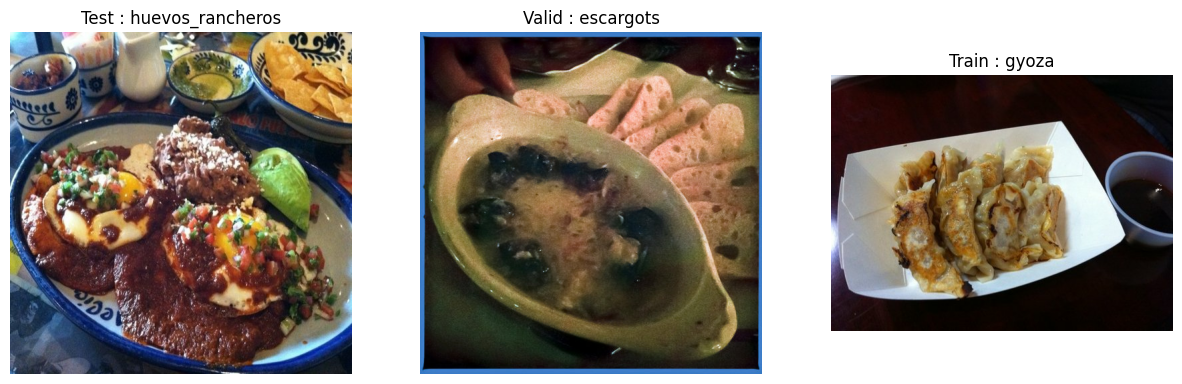

In [6]:
display_image_and_details(test_set_raw.take(1), valid_set_raw.take(1), train_set_raw.take(1))